In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
### Filter out corrupted data
# When working with lots of real-world image data, corrupted images are a common occurence. 
# Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.



import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


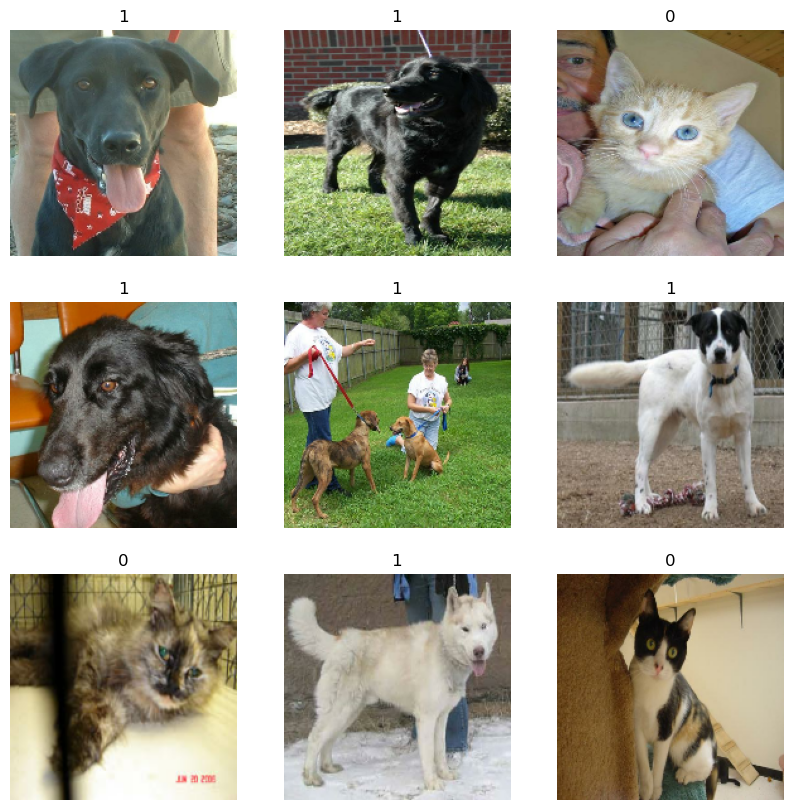

In [9]:
### Visualize the data
# Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))


for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
### Using image data augmentation
# When you don't have a large image dataset, it's a good practice to artificially introduce sample 
# diversity by applying random yet realistic transformations to the training images, such as random horizontal 
# flipping or small random rotations. This helps expose the model to different aspects of the training data 
# while slowing down overfitting.

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


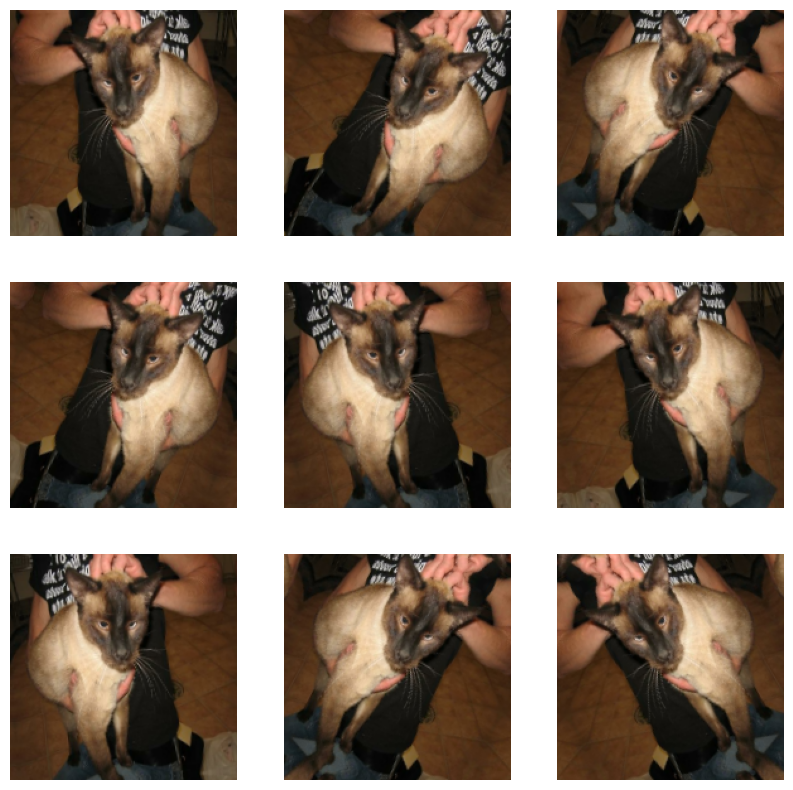

In [12]:
# Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly 
# to the first image in the dataset:    
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
## Configure the dataset for performance
# Let's apply data augmentation to our training dataset, and let's make sure to use buffered 
# prefetching so we can yield data from disk without having I/O becoming blocking:
# Apply `data_augmentation` to the training images.

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 [============>.................] - ETA: 17:01 - loss: 0.6888 - accuracy: 0.6118

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 [=============>................] - ETA: 15:23 - loss: 0.6870 - accuracy: 0.6099

 91/147 [=================>............] - ETA: 11:29 - loss: 0.6743 - accuracy: 0.6213

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 [==================>...........] - ETA: 10:52 - loss: 0.6725 - accuracy: 0.6233

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 [==================>...........] - ETA: 10:15 - loss: 0.6694 - accuracy: 0.6256

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/147 [===================>..........] - ETA: 10:02 - loss: 0.6688 - accuracy: 0.6260

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6467 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 1876s 13s/step - loss: 0.6445 - accuracy: 0.6467 - val_loss: 0.8776 - val_accuracy: 0.4957
Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 [============>.................] - ETA: 29:29 - loss: 0.5228 - accuracy: 0.7440

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 [=============>................] - ETA: 25:29 - loss: 0.5152 - accuracy: 0.7492

 91/147 [=================>............] - ETA: 17:31 - loss: 0.5055 - accuracy: 0.7582

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 [==================>...........] - ETA: 16:24 - loss: 0.5042 - accuracy: 0.7588

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 [==================>...........] - ETA: 15:19 - loss: 0.5009 - accuracy: 0.7605

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/147 [===================>..........] - ETA: 14:58 - loss: 0.5000 - accuracy: 0.7608

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.7756 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 2468s 17s/step - loss: 0.4769 - accuracy: 0.7756 - val_loss: 1.4973 - val_accuracy: 0.4957
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 [============>.................] - ETA: 17:18 - loss: 0.4085 - accuracy: 0.8180

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 72/147 [=============>................] - ETA: 15:35 - loss: 0.4053 - accuracy: 0.8200

 91/147 [=================>............] - ETA: 11:39 - loss: 0.3956 - accuracy: 0.8249

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/147 [==================>...........] - ETA: 11:01 - loss: 0.3988 - accuracy: 0.8235

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 97/147 [==================>...........] - ETA: 10:24 - loss: 0.3970 - accuracy: 0.8244

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/147 [===================>..........] - ETA: 10:11 - loss: 0.3973 - accuracy: 0.8244

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8295 

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 1895s 13s/step - loss: 0.3857 - accuracy: 0.8295 - val_loss: 0.8804 - val_accuracy: 0.5028
Epoch 4/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/147 [============>.................] - ETA: 44:31 - loss: 0.3445 - accuracy: 0.8521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:06:48 - loss: 0.3436 - accuracy: 0.8527

KeyboardInterrupt: 

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")